In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from alexnet import AlexNet
from lenet5 import LeNet5
from data_loading import DataLoaderCreator
import re
from prototypical_networks import *
from soft_voting import SoftVotingClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def load_model(model, model_path, dropout_rate=0, init_type='random'):
    """Loads a model from a specified path and initializes it with given parameters"""
    if model == 'alexnet':
        model = AlexNet(dropout_rate=dropout_rate, init_type=init_type)
    elif model == 'lenet5':
        model = LeNet5(dropout_rate=dropout_rate, init_type=init_type)
    else:
        raise ValueError("Invalid model name")
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # CPU/GPU
    model.eval()
    return model

In [26]:
def evaluate_model(model, test_loader, device):
    """ Evaluates the model on a given test dataset and computes accuracy, precision, recall, and F1-score."""
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100

    precision = precision_score(all_labels, all_preds, average='macro', zero_division=1) * 100
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=1) * 100
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=1) * 100

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

In [24]:
def evaluate_models(model_paths, test_loader, device, model_name):
    """
    Evaluates multiple models and computes mean and standard deviation for accuracy, precision, recall, and F1-score.
    """
    metrics = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}

    for model_path in model_paths:
        print(f"Evaluating {model_path} ({model_name})...")
        model = load_model("alexnet", model_path, dropout_rate=0, init_type='random')
        results = evaluate_model(model, test_loader, device)

        for key in metrics.keys():
            metrics[key].append(results[key])

        print(f"Accuracy: {results['accuracy']:.2f}%, Precision: {results['precision']:.2f}%, Recall: {results['recall']:.2f}%, F1: {results['f1_score']:.2f}%")

    final_results = {metric: (np.mean(values), np.std(values, ddof=1)) for metric, values in metrics.items()}

    return final_results

In [8]:
def load_loss_data(pattern):
    """Function for loading loss"""
    csv_files = glob.glob(pattern)
    all_data = []

    for file in csv_files:
        match = re.search(r"seed_(\d+)", file)
        seed = int(match.group(1))
        df = pd.read_csv(file, names=["train_loss", "valid_loss"], header=0)
        df["epoch"] = df.index
        df["seed"] = seed
        all_data.append(df)

    df_all = pd.concat(all_data)

    df_grouped = df_all.groupby("epoch").agg(
        train_loss_mean=("train_loss", "mean"),
        train_loss_std=("train_loss", "std"),
        valid_loss_mean=("valid_loss", "mean"),
        valid_loss_std=("valid_loss", "std")
    ).reset_index()

    return df_grouped


In [11]:
def plot_loss(df, model_name, train_color, valid_color, plot_train=True, plot_valid=True):
    """
    Function for plotting loss values.

    Parameters:
    - df: DataFrame containing loss values
    - model_name: Model name printed on legend (e.g., 'Random Flipping')
    - lr: Learning rate value
    - train_color: Color for train loss
    - valid_color: Color for validation loss
    - plot_train: Whether to plot train loss (default: True)
    - plot_valid: Whether to plot validation loss (default: True)
"""
    plt.ylim(1.5,5)
    if plot_train:
        train_label = f"Train Loss: {model_name}"
        plt.plot(df["epoch"], df["train_loss_mean"], label=train_label, color=train_color)
        plt.fill_between(df["epoch"],
                         df["train_loss_mean"] - df["train_loss_std"],
                         df["train_loss_mean"] + df["train_loss_std"],
                         color=train_color, alpha=0.2)

    if plot_valid:
        valid_label = f"Valid Loss: {model_name}"
        plt.plot(df["epoch"], df["valid_loss_mean"], label=valid_label, color=valid_color)
        plt.fill_between(df["epoch"],
                         df["valid_loss_mean"] - df["valid_loss_std"],
                         df["valid_loss_mean"] + df["valid_loss_std"],
                         color=valid_color, alpha=0.2)

In [60]:
def generate_confusion_matrix(model_type, model_path, test_loader, save_path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = load_model(model_type, model_path)
    model = model.to(device)
    model.eval()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    if save_path:
        if save_path.endswith('.csv'):
            cm_df = pd.DataFrame(cm, index=test_loader.dataset.classes, columns=test_loader.dataset.classes)
            cm_df.to_csv(save_path, index=True)
        elif save_path.endswith('.txt'):
            np.savetxt(save_path, cm, fmt='%d', delimiter='\t')
        elif save_path.endswith('.png') or save_path.endswith('.jpg'):
            plt.savefig(save_path, dpi=300)
        else:
            print("Unsupported file extension. Supported extensions: .csv, .txt, .png, .jpg.")
            return

    plt.show()

In [61]:
from sklearn.metrics import precision_recall_fscore_support


def evaluate_model_soft(voting_classifier, test_loader, save_path=None):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = voting_classifier.predict(inputs)
            all_preds.extend(outputs)
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    class_names = test_loader.dataset.classes

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()

    return acc, precision, recall, f1

In [33]:
loader_creator = DataLoaderCreator(seed=123)
test_loader = loader_creator.create_data_loader('cinic-10/test', batch_size=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Lenet5 - Hyper-parameters

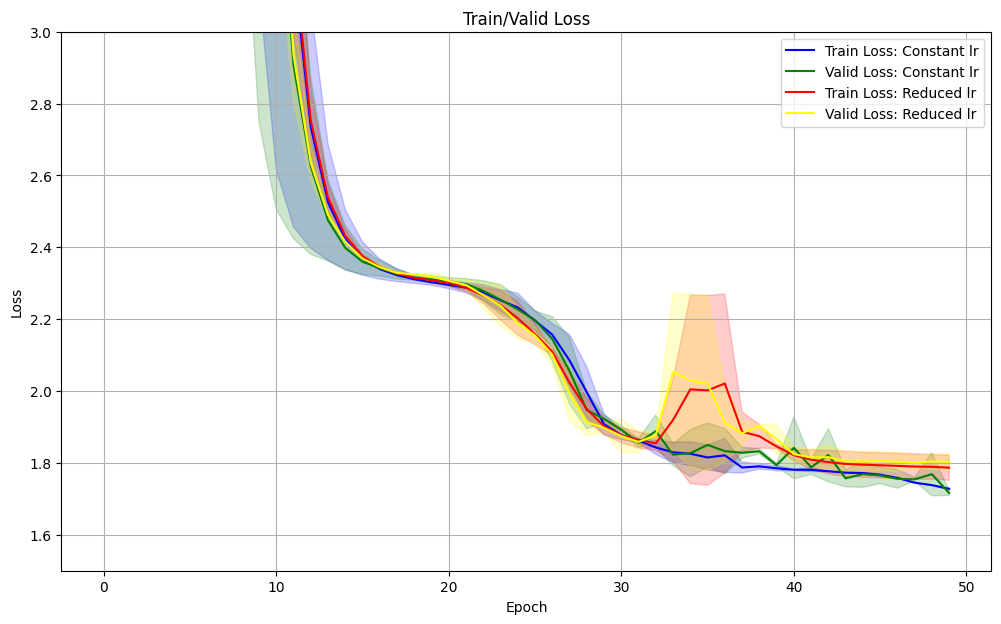

In [119]:
df_lenet5_co = load_loss_data("saved_losses/lenet5_constant_lr_0.01_seed_*.csv")
df_lenet5_re = load_loss_data("saved_losses/lenet5_lr_reduce_0.01_seed_*.csv")

plt.figure(figsize=(12, 7))

plot_loss(df_lenet5_co, "Constant lr", train_color="blue", valid_color="green")
plot_loss(df_lenet5_re, "Reduced lr", train_color="red", valid_color="yellow")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Valid Loss")
plt.legend()
plt.grid()
plt.savefig("plots/lenet5_lr")
plt.show()

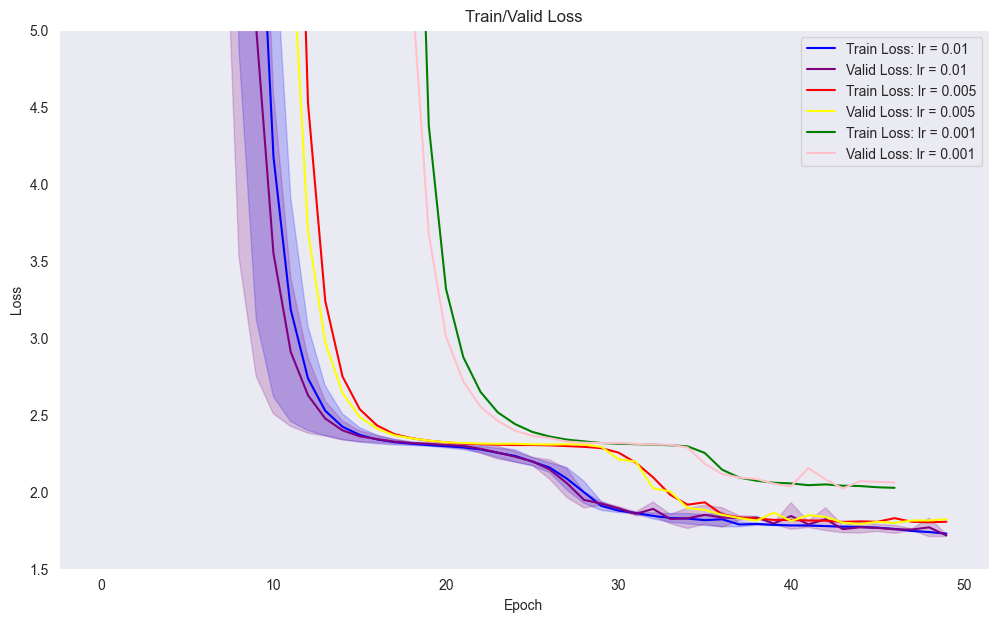

In [12]:
df_lenet5_co = load_loss_data("saved_losses/lenet5_constant_lr_0.01_seed_*.csv")
df_lenet5_co1 = load_loss_data("saved_losses/lenet5_constant_lr_0.005_seed_*.csv")
df_lenet5_co2 = load_loss_data("saved_losses/lenet5_constant_lr_0.001_seed_*.csv")

plt.figure(figsize=(12, 7))

plot_loss(df_lenet5_co, "lr = 0.01", train_color="blue", valid_color="purple")
plot_loss(df_lenet5_co1, "lr = 0.005", train_color="red", valid_color="yellow")
plot_loss(df_lenet5_co2, "lr = 0.001", train_color="green", valid_color="pink")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Valid Loss")
plt.legend()
plt.grid()
plt.savefig("plots/lenet5_lrdiff")
plt.show()

In [120]:
model_paths = {
    'Constant lr': glob.glob("saved_models/lenet5_constant_lr_0.01_seed_*.pth"),
    'Reduced lr': glob.glob("saved_models/lenet5_lr_reduce_0.01_seed_*.pth"),
}

results = {}

for model_name, paths in model_paths.items():
    results[model_name] = evaluate_models(paths, test_loader, device, model_name)

for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, (mean, std) in metrics.items():
        print(f"{metric.capitalize()}: {mean:.2f}% ± {std:.2f}%")

Evaluating saved_models\lenet5_constant_lr_0.01_seed_123.pth (Constant lr)...
Accuracy: 32.11%, Precision: 32.43%, Recall: 32.11%, F1: 29.22%
Evaluating saved_models\lenet5_constant_lr_0.01_seed_33.pth (Constant lr)...
Accuracy: 26.73%, Precision: 27.05%, Recall: 26.73%, F1: 23.56%
Evaluating saved_models\lenet5_constant_lr_0.01_seed_40.pth (Constant lr)...
Accuracy: 32.50%, Precision: 31.06%, Recall: 32.50%, F1: 29.67%
Evaluating saved_models\lenet5_lr_reduce_0.01_seed_123.pth (Reduced lr)...
Accuracy: 31.09%, Precision: 29.84%, Recall: 31.09%, F1: 29.78%
Evaluating saved_models\lenet5_lr_reduce_0.01_seed_33.pth (Reduced lr)...
Accuracy: 26.23%, Precision: 26.71%, Recall: 26.23%, F1: 21.91%
Evaluating saved_models\lenet5_lr_reduce_0.01_seed_40.pth (Reduced lr)...
Accuracy: 27.56%, Precision: 26.60%, Recall: 27.56%, F1: 22.93%

Constant lr:
Accuracy: 30.45% ± 3.22%
Precision: 30.18% ± 2.80%
Recall: 30.45% ± 3.22%
F1_score: 27.48% ± 3.41%

Reduced lr:
Accuracy: 28.29% ± 2.51%
Precision:

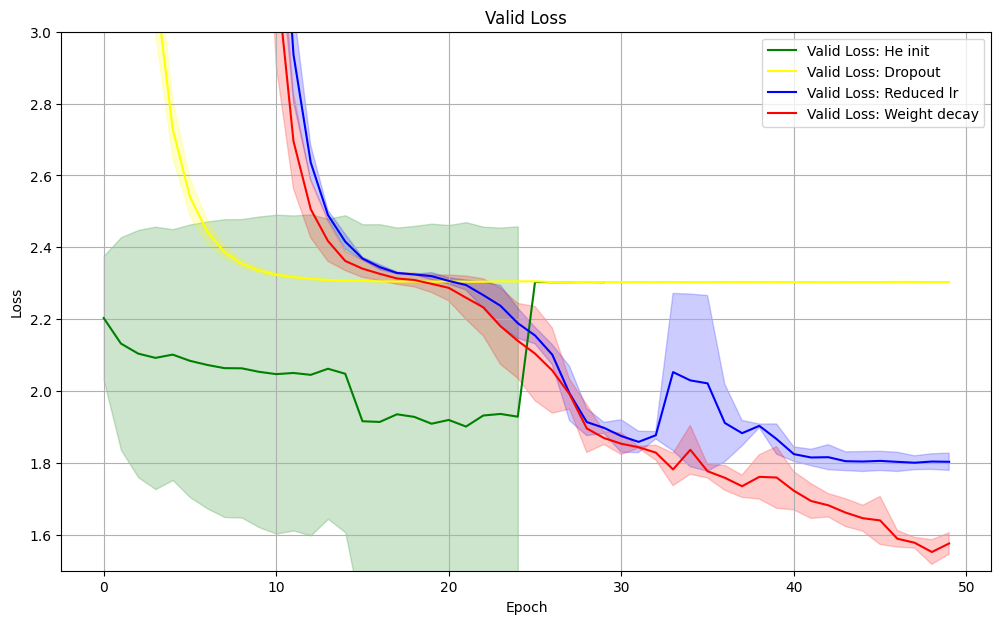

In [110]:
df_lenet5_he = load_loss_data("saved_losses/lenet5_he_init_seed_*.csv")
df_lenet5_dr = load_loss_data("saved_losses/lenet5_dropout_seed_*.csv")
df_lenet5_we = load_loss_data("saved_losses/lenet5_weight_decay_*.csv")

plt.figure(figsize=(12, 7))

plot_loss(df_lenet5_he, "He init", train_color="blue", valid_color="green", plot_train=False)
plot_loss(df_lenet5_dr, "Dropout", train_color="red", valid_color="yellow", plot_train=False)
plot_loss(df_lenet5_re, "Reduced lr", train_color="purple", valid_color="blue", plot_train=False)
plot_loss(df_lenet5_we, "Weight decay", train_color="purple", valid_color="red", plot_train=False)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Valid Loss")
plt.legend()
plt.grid()
plt.savefig("plots/lenet5_drop")
plt.show()

In [113]:
model_paths = {
    'He init': glob.glob("saved_models/lenet5_he_init_seed_*.pth"),
    'Dropout': glob.glob("saved_models/lenet5_dropout_seed_*.pth"),
    'Weight decay': glob.glob("saved_models/lenet5_weight_decay_seed_*.pth")
}

results = {}

for model_name, paths in model_paths.items():
    results[model_name] = evaluate_models(paths, test_loader, device, model_name)

for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, (mean, std) in metrics.items():
        print(f"{metric.capitalize()}: {mean:.2f}% ± {std:.2f}%")

Evaluating saved_models\lenet5_he_init_seed_123.pth (He init)...
Accuracy: 10.00%, Precision: 91.00%, Recall: 10.00%, F1: 1.82%
Evaluating saved_models\lenet5_he_init_seed_33.pth (He init)...
Accuracy: 42.40%, Precision: 45.70%, Recall: 42.40%, F1: 41.37%
Evaluating saved_models\lenet5_he_init_seed_40.pth (He init)...
Accuracy: 10.00%, Precision: 91.00%, Recall: 10.00%, F1: 1.82%
Evaluating saved_models\lenet5_dropout_seed_123.pth (Dropout)...
Accuracy: 10.01%, Precision: 37.99%, Recall: 10.01%, F1: 1.84%
Evaluating saved_models\lenet5_dropout_seed_33.pth (Dropout)...
Accuracy: 10.00%, Precision: 16.76%, Recall: 10.00%, F1: 1.83%
Evaluating saved_models\lenet5_dropout_seed_40.pth (Dropout)...
Accuracy: 10.00%, Precision: 71.00%, Recall: 10.00%, F1: 1.82%
Evaluating saved_models\lenet5_weight_decay_seed_123.pth (Weight decay)...
Accuracy: 40.92%, Precision: 44.47%, Recall: 40.92%, F1: 40.06%
Evaluating saved_models\lenet5_weight_decay_seed_33.pth (Weight decay)...
Accuracy: 42.74%, Prec

Alexnet - Hyper-parameters

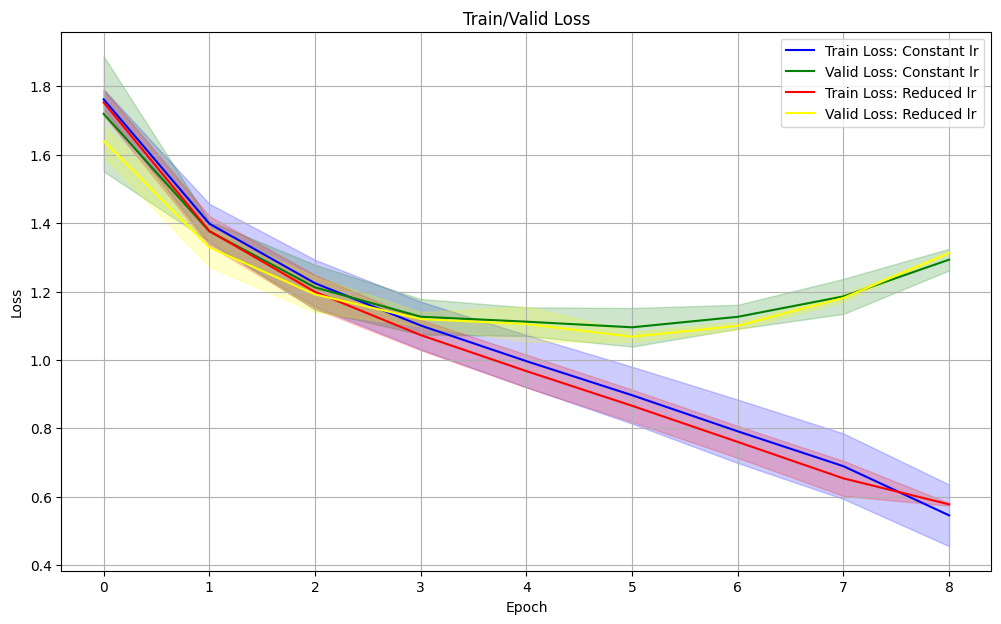

In [125]:
df_alexnet_co = load_loss_data("saved_losses/alexnet_constant_lr_0.001_seed_*.csv")
df_alexnet_re = load_loss_data("saved_losses/alexnet_lr_reduce_0.001_seed_*.csv")

plt.figure(figsize=(12, 7))

plot_loss(df_alexnet_co, "Constant lr", train_color="blue", valid_color="green")
plot_loss(df_alexnet_re, "Reduced lr", train_color="red", valid_color="yellow")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Valid Loss")
plt.legend()
plt.grid()
plt.savefig("plots/alexnet_lr")
plt.show()


In [126]:
model_paths = {
    'Constant lr': glob.glob("saved_models/alexnet_constant_lr_0.001_seed_*.pth"),
    'Reduced lr': glob.glob("saved_models/alexnet_lr_reduce_0.001_seed_*.pth"),
}

results = {}

for model_name, paths in model_paths.items():
    results[model_name] = evaluate_models(paths, test_loader, device, model_name)

for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, (mean, std) in metrics.items():
        print(f"{metric.capitalize()}: {mean:.2f}% ± {std:.2f}%")

Evaluating saved_models\alexnet_constant_lr_0.001_seed_123.pth (Constant lr)...
Accuracy: 58.89%, Precision: 59.29%, Recall: 58.89%, F1: 58.26%
Evaluating saved_models\alexnet_constant_lr_0.001_seed_33.pth (Constant lr)...
Accuracy: 62.41%, Precision: 62.49%, Recall: 62.41%, F1: 62.38%
Evaluating saved_models\alexnet_constant_lr_0.001_seed_40.pth (Constant lr)...
Accuracy: 60.79%, Precision: 61.82%, Recall: 60.79%, F1: 60.64%
Evaluating saved_models\alexnet_lr_reduce_0.001_seed_123.pth (Reduced lr)...
Accuracy: 61.81%, Precision: 61.49%, Recall: 61.81%, F1: 61.42%
Evaluating saved_models\alexnet_lr_reduce_0.001_seed_33.pth (Reduced lr)...
Accuracy: 62.95%, Precision: 63.30%, Recall: 62.95%, F1: 62.95%
Evaluating saved_models\alexnet_lr_reduce_0.001_seed_40.pth (Reduced lr)...
Accuracy: 61.09%, Precision: 61.58%, Recall: 61.09%, F1: 60.59%

Constant lr:
Accuracy: 60.70% ± 1.76%
Precision: 61.20% ± 1.69%
Recall: 60.70% ± 1.76%
F1_score: 60.43% ± 2.07%

Reduced lr:
Accuracy: 61.95% ± 0.94

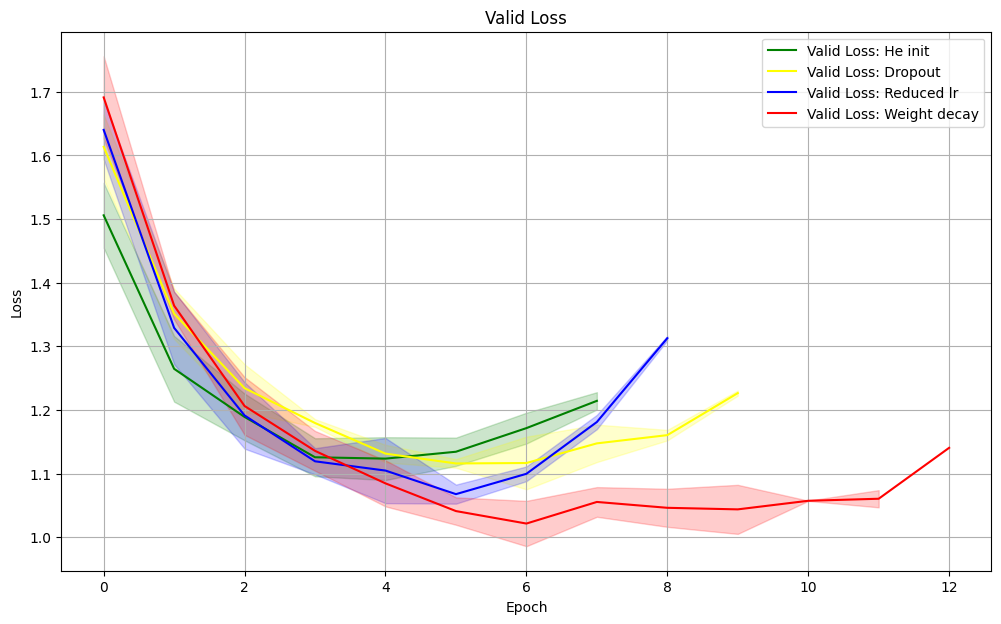

In [127]:
df_alexnet_he = load_loss_data("saved_losses/alexnet_he_init_seed_*.csv")
df_alexnet_dr = load_loss_data("saved_losses/alexnet_dropout_seed_*.csv")
df_alexnet_we = load_loss_data("saved_losses/alexnet_weight_decay_*.csv")

plt.figure(figsize=(12, 7))

plot_loss(df_alexnet_he, "He init", train_color="blue", valid_color="green", plot_train=False)
plot_loss(df_alexnet_dr, "Dropout", train_color="red", valid_color="yellow", plot_train=False)
plot_loss(df_alexnet_re, "Reduced lr", train_color="purple", valid_color="blue", plot_train=False)
plot_loss(df_alexnet_we, "Weight decay", train_color="purple", valid_color="red", plot_train=False)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Valid Loss")
plt.legend()
plt.grid()
plt.savefig("plots/alexnet_drop")
plt.show()

In [128]:
model_paths = {
    'He init': glob.glob("saved_models/alexnet_he_init_seed_*.pth"),
    'Dropout': glob.glob("saved_models/alexnet_dropout_seed_*.pth"),
    'Weight decay': glob.glob("saved_models/alexnet_weight_decay_seed_*.pth")
}

results = {}

for model_name, paths in model_paths.items():
    results[model_name] = evaluate_models(paths, test_loader, device, model_name)

for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, (mean, std) in metrics.items():
        print(f"{metric.capitalize()}: {mean:.2f}% ± {std:.2f}%")

Evaluating saved_models\alexnet_he_init_seed_123.pth (He init)...
Accuracy: 60.29%, Precision: 59.89%, Recall: 60.29%, F1: 59.91%
Evaluating saved_models\alexnet_he_init_seed_33.pth (He init)...
Accuracy: 60.16%, Precision: 60.80%, Recall: 60.16%, F1: 59.79%
Evaluating saved_models\alexnet_he_init_seed_40.pth (He init)...
Accuracy: 61.04%, Precision: 61.83%, Recall: 61.04%, F1: 61.09%
Evaluating saved_models\alexnet_dropout_seed_123.pth (Dropout)...
Accuracy: 61.06%, Precision: 61.50%, Recall: 61.06%, F1: 60.77%
Evaluating saved_models\alexnet_dropout_seed_33.pth (Dropout)...
Accuracy: 61.17%, Precision: 61.76%, Recall: 61.17%, F1: 61.31%
Evaluating saved_models\alexnet_dropout_seed_40.pth (Dropout)...
Accuracy: 59.54%, Precision: 60.11%, Recall: 59.54%, F1: 59.38%
Evaluating saved_models\alexnet_weight_decay_seed_123.pth (Weight decay)...
Accuracy: 63.12%, Precision: 64.53%, Recall: 63.12%, F1: 63.00%
Evaluating saved_models\alexnet_weight_decay_seed_33.pth (Weight decay)...
Accuracy:

Lenet5 - Data Augmentation

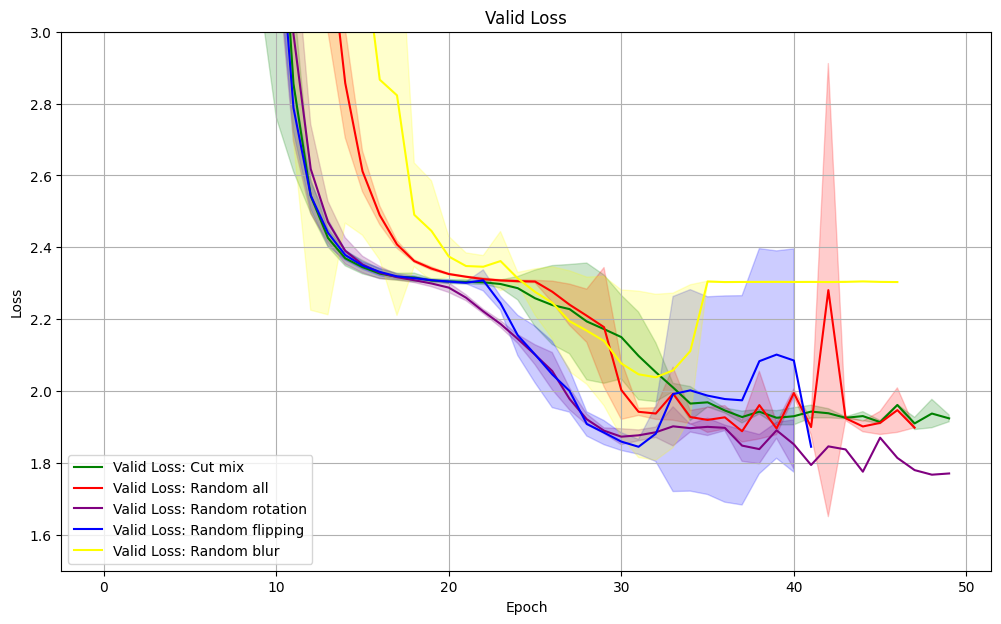

In [114]:
df_lenet5_ra = load_loss_data("saved_losses/lenet5_random_all_seed_*.csv")
df_lenet5_rf = load_loss_data("saved_losses/lenet5_random_flipping_seed_*.csv")
df_lenet5_rb = load_loss_data("saved_losses/lenet5_random_blur_seed_*.csv")
df_lenet5_cm = load_loss_data("saved_losses/lenet5_cut_mix_seed_*.csv")
df_lenet5_rr = load_loss_data("saved_losses/lenet5_random_rotation_seed_*.csv")


plt.figure(figsize=(12, 7))

plot_loss(df_lenet5_cm, "Cut mix", train_color="blue", valid_color="green", plot_train=False)
plot_loss(df_lenet5_ra, "Random all", train_color="blue", valid_color="red", plot_train=False)
plot_loss(df_lenet5_rr, "Random rotation", train_color="blue", valid_color="purple", plot_train=False)
plot_loss(df_lenet5_rf, "Random flipping", train_color="blue", valid_color="blue", plot_train=False)
plot_loss(df_lenet5_rb, "Random blur", train_color="blue", valid_color="yellow", plot_train=False)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Valid Loss")
plt.legend()
plt.grid()
plt.savefig("plots/lenet5_augmentation")
plt.show()


In [116]:
model_paths = {
    'Random all': glob.glob("saved_models/lenet5_random_all_seed_*.pth"),
    'Random flipping': glob.glob("saved_models/lenet5_random_flipping_seed_*.pth"),
    'Random blur': glob.glob("saved_models/lenet5_random_blur_seed_*.pth"),
    'Random rotation': glob.glob("saved_models/lenet5_random_rotation_seed_*.pth"),
    'Cut mix': glob.glob("saved_models/lenet5_cut_mix_seed_*.pth")
}

results = {}

for model_name, paths in model_paths.items():
    results[model_name] = evaluate_models(paths, test_loader, device, model_name)

for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, (mean, std) in metrics.items():
        print(f"{metric.capitalize()}: {mean:.2f}% ± {std:.2f}%")



Evaluating saved_models\lenet5_random_all_seed_123.pth (Random all)...
Accuracy: 25.69%, Precision: 24.98%, Recall: 25.69%, F1: 23.20%
Evaluating saved_models\lenet5_random_all_seed_33.pth (Random all)...
Accuracy: 10.00%, Precision: 81.00%, Recall: 10.00%, F1: 1.82%
Evaluating saved_models\lenet5_random_all_seed_40.pth (Random all)...
Accuracy: 26.08%, Precision: 39.04%, Recall: 26.08%, F1: 19.71%
Evaluating saved_models\lenet5_random_flipping_seed_123.pth (Random flipping)...
Accuracy: 10.00%, Precision: 91.00%, Recall: 10.00%, F1: 1.82%
Evaluating saved_models\lenet5_random_flipping_seed_33.pth (Random flipping)...
Accuracy: 31.37%, Precision: 32.01%, Recall: 31.37%, F1: 28.61%
Evaluating saved_models\lenet5_random_flipping_seed_40.pth (Random flipping)...
Accuracy: 28.28%, Precision: 26.77%, Recall: 28.28%, F1: 24.40%
Evaluating saved_models\lenet5_random_blur_seed_123.pth (Random blur)...
Accuracy: 10.00%, Precision: 91.00%, Recall: 10.00%, F1: 1.82%
Evaluating saved_models\lenet5

Alexnet - Data Augmentation

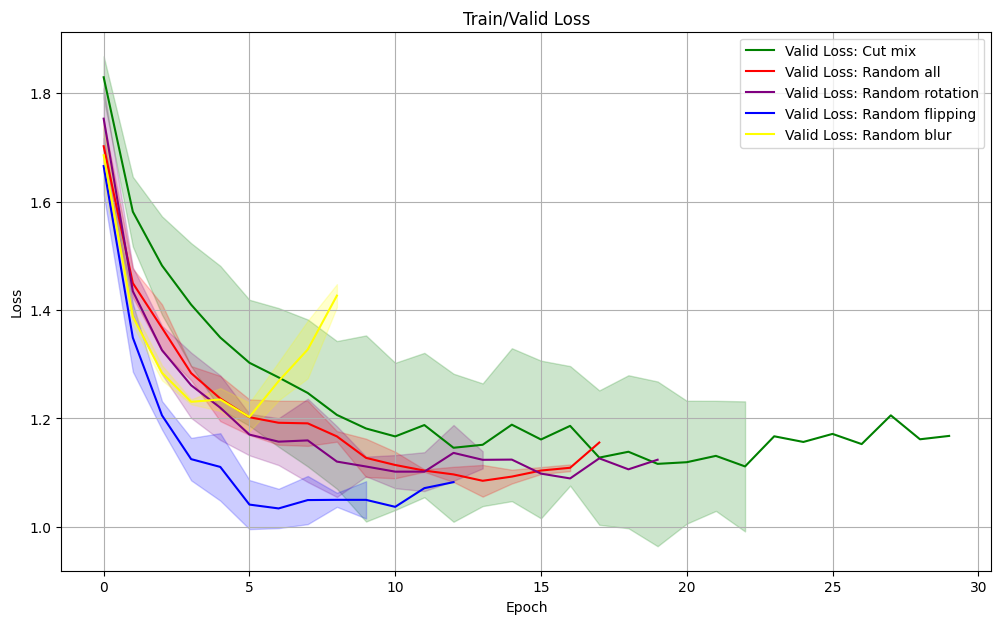

In [129]:
df_alexnet_ra = load_loss_data("saved_losses/alexnet_random_all_seed_*.csv")
df_alexnet_rf = load_loss_data("saved_losses/alexnet_random_flipping_seed_*.csv")
df_alexnet_rb = load_loss_data("saved_losses/alexnet_random_blur_seed_*.csv")
df_alexnet_cm = load_loss_data("saved_losses/alexnet_cut_mix_seed_*.csv")
df_alexnet_rr = load_loss_data("saved_losses/alexnet_random_rotation_seed_*.csv")


plt.figure(figsize=(12, 7))

plot_loss(df_alexnet_cm, "Cut mix", train_color="blue", valid_color="green", plot_train=False)
plot_loss(df_alexnet_ra, "Random all", train_color="blue", valid_color="red", plot_train=False)
plot_loss(df_alexnet_rr, "Random rotation", train_color="blue", valid_color="purple", plot_train=False)
plot_loss(df_alexnet_rf, "Random flipping", train_color="blue", valid_color="blue", plot_train=False)
plot_loss(df_alexnet_rb, "Random blur", train_color="blue", valid_color="yellow", plot_train=False)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Valid Loss")
plt.legend()
plt.grid()
plt.savefig("plots/alexnet_augmentation")
plt.show()


In [130]:
model_paths = {
    'Random all': glob.glob("saved_models/alexnet_random_all_seed_*.pth"),
    'Random flipping': glob.glob("saved_models/alexnet_random_flipping_seed_*.pth"),
    'Random blur': glob.glob("saved_models/alexnet_random_blur_seed_*.pth"),
    'Random rotation': glob.glob("saved_models/alexnet_random_rotation_seed_*.pth"),
    'Cut mix': glob.glob("saved_models/alexnet_cut_mix_seed_*.pth")
}

results = {}

for model_name, paths in model_paths.items():
    results[model_name] = evaluate_models(paths, test_loader, device, model_name)

for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, (mean, std) in metrics.items():
        print(f"{metric.capitalize()}: {mean:.2f}% ± {std:.2f}%")



Evaluating saved_models\alexnet_random_all_seed_123.pth (Random all)...
Accuracy: 62.36%, Precision: 63.36%, Recall: 62.36%, F1: 61.87%
Evaluating saved_models\alexnet_random_all_seed_33.pth (Random all)...
Accuracy: 62.60%, Precision: 62.29%, Recall: 62.60%, F1: 61.88%
Evaluating saved_models\alexnet_random_all_seed_40.pth (Random all)...
Accuracy: 60.88%, Precision: 60.88%, Recall: 60.88%, F1: 60.01%
Evaluating saved_models\alexnet_random_flipping_seed_123.pth (Random flipping)...
Accuracy: 64.37%, Precision: 64.87%, Recall: 64.37%, F1: 64.21%
Evaluating saved_models\alexnet_random_flipping_seed_33.pth (Random flipping)...
Accuracy: 62.77%, Precision: 63.63%, Recall: 62.77%, F1: 62.93%
Evaluating saved_models\alexnet_random_flipping_seed_40.pth (Random flipping)...
Accuracy: 64.37%, Precision: 65.11%, Recall: 64.37%, F1: 64.04%
Evaluating saved_models\alexnet_random_blur_seed_123.pth (Random blur)...
Accuracy: 58.59%, Precision: 58.58%, Recall: 58.59%, F1: 58.37%
Evaluating saved_mod

Protonet


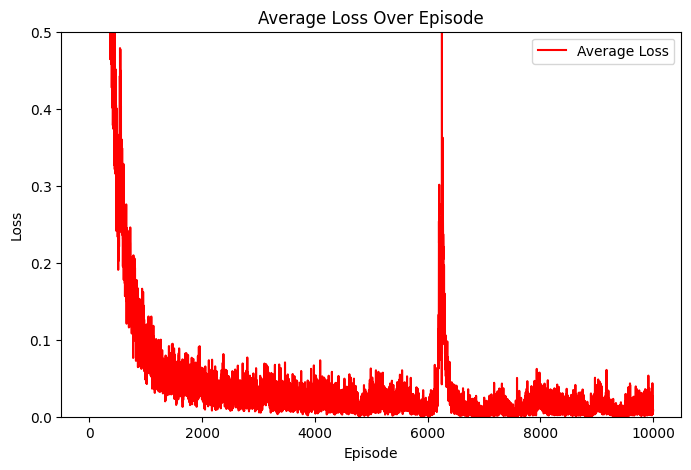

In [29]:
file_pattern = "saved_losses/protonet_10-20-10000-100-0.1_lr_0.001_seed_*.csv"
files = glob.glob(file_pattern)

losses = []

for file in files:
    df = pd.read_csv(file)
    losses.append(df['loss'].values)

losses = pd.DataFrame(losses).mean(axis=0)

plt.figure(figsize=(8, 5))
plt.ylim(0,0.5)
plt.plot(losses, label='Average Loss', color='red')

plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Average Loss Over Episode')
plt.legend()
plt.savefig('plots/protonet.png')
plt.show()

Softvoting


In [62]:
model1 = load_model('alexnet', "saved_models/alexnet_lr_reduce_0.001_seed_33.pth")
model2 = load_model('alexnet', "saved_models/alexnet_weight_decay_seed_33.pth")
model3 = load_model('alexnet', "saved_models/alexnet_random_flipping_seed_123.pth")

classifiers = [model1, model2, model3]

weights = [0.3, 0.4, 0.3]

voting_classifier = SoftVotingClassifier(classifiers, weights)

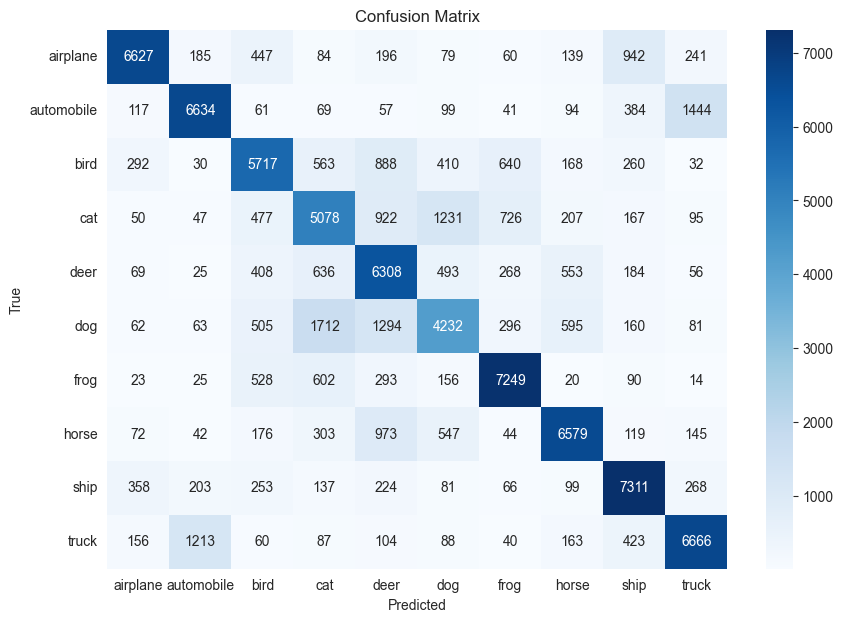

Accuracy: 0.6933
Precision: 0.6969
Recall: 0.6933
F1 Score: 0.6930


In [63]:
acc, precision, recall, f1 = evaluate_model_soft(voting_classifier, test_loader, 'plots/cm_alexnet_soft.png')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [64]:
model1 = load_model('lenet5', "saved_models/lenet5_constant_lr_0.01_seed_123.pth")
model2 = load_model('lenet5', "saved_models/lenet5_weight_decay_seed_33.pth")
model3 = load_model('lenet5', "saved_models/lenet5_random_flipping_seed_33.pth")


classifiers = [model1, model2, model3]

weights = [0.3, 0.4, 0.3]

voting_classifier_lenet5 = SoftVotingClassifier(classifiers, weights)

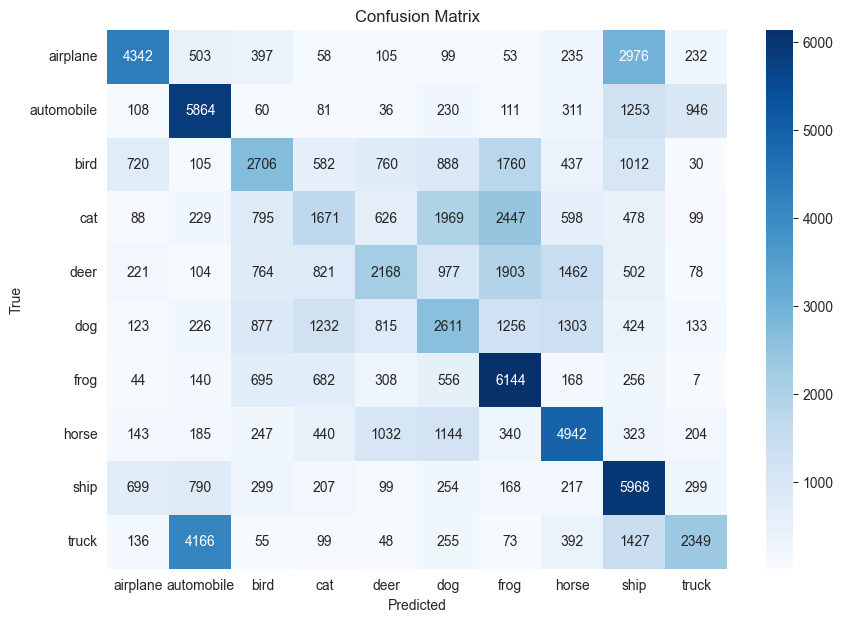

Accuracy: 0.4307
Precision: 0.4328
Recall: 0.4307
F1 Score: 0.4154


In [65]:
acc, precision, recall, f1 = evaluate_model_soft(voting_classifier_lenet5, test_loader, 'plots/cm_lenet5_soft.png')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Confusion matrix

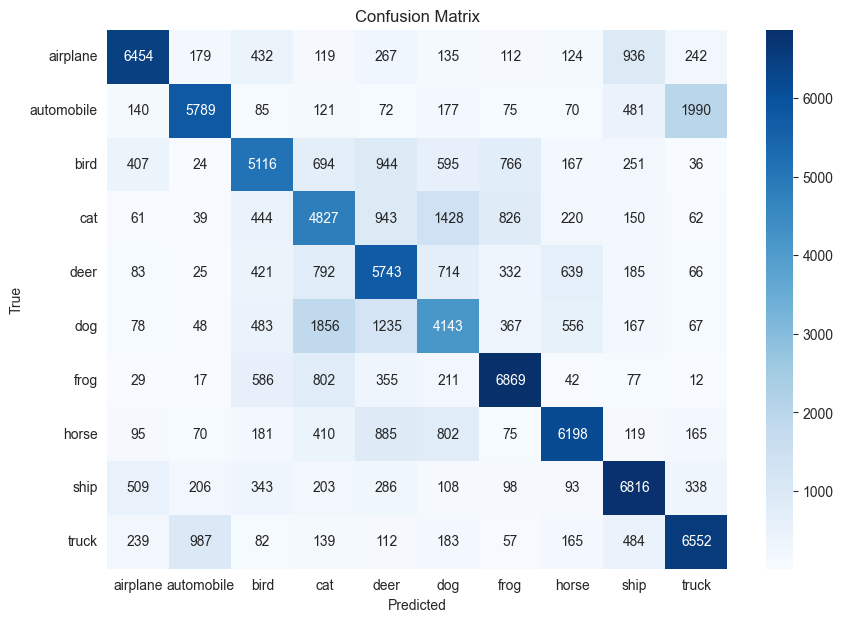

In [66]:
generate_confusion_matrix(
    model_type='alexnet',
    model_path='saved_models/alexnet_weight_decay_seed_33.pth',
    test_loader=test_loader,
    save_path='plots/cm_alexnet_weight.png'
)

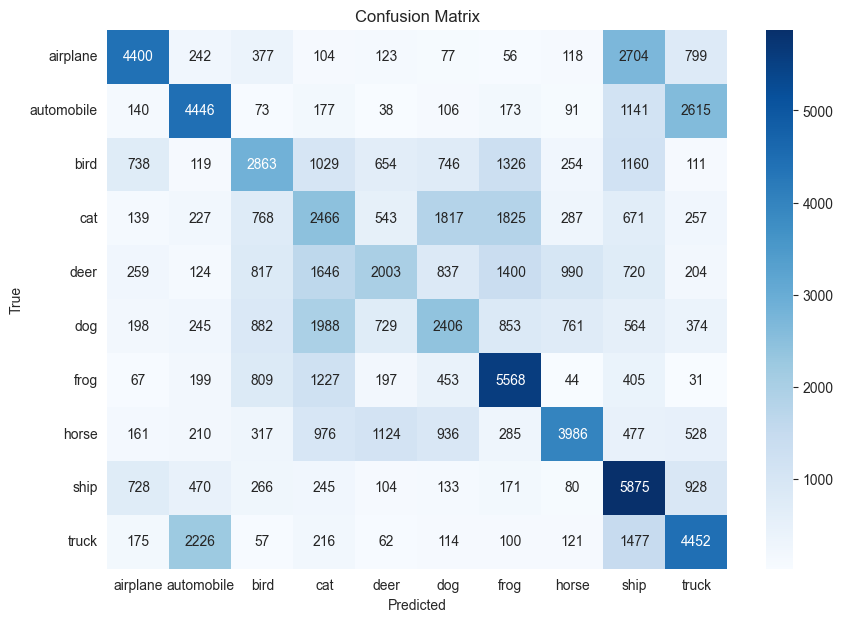

In [67]:
generate_confusion_matrix(
    model_type='lenet5',
    model_path='saved_models/lenet5_weight_decay_seed_33.pth',
    test_loader=test_loader,
    save_path='plots/cm_lenet5_weight.png'
)